## 주가예측 

### 주가 예측을 위한 지도 학습 모델 

#### 문제정의 

Microsoft 주식의 주 단위 수익을 예측되는 변수로 사용하며, 무엇이 Microsoft 주가에 영향을 주는지 이해하고, 가능한 많은 정보를 모델에 포함.   
**특성인 상관 자산에 집중한다.**

목표변수 - Microsoft EPS  
독립변수 - 주식(알파벳) , 환율(미국 달러/엔화 및 파운드/미국 달러), 인덱스(S&P 500, 다우존스, 변동성 지수)

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

import pandas_datareader.data as web
import pandas_datareader as pdr
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

In [163]:
# 지도 회귀 모델을 위한 함수와 모듈 

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso # 선형 회귀에 L1 규제 계수를 적용
from sklearn.linear_model import ElasticNet # 가중치의 절대값의 합(L1)과 제곱합(L2)을 동시에 제약 조건으로 가지는 모형
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

In [8]:
# 데이터 분석 및 모델 평가를 위한 함수와 모듈 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2, f_regression # 카이제곱 검정 통계값,  분산분석(ANOVA) F검정 통계값

In [5]:
# 딥러닝을 위한 함수와 모듈

from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

In [6]:
# 시계열 모델을 위한 함수와 모듈

import statsmodels.api as sm # 변수별 회귀계수
from statsmodels.tsa.arima_model import ARIMA

### 데이터 불러오기

In [84]:
ms = pdr.get_data_yahoo('msft')
ibm = pdr.get_data_yahoo('ibm')
googl= pdr.get_data_yahoo('googl')

In [85]:
display(ms.head(3), ibm.head(3),googl.head(3))

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-03-17,65.239998,64.680000,64.910004,64.870003,49219700.0,60.555153
2017-03-20,65.180000,64.720001,64.910004,64.930000,14598100.0,60.611168
2017-03-21,65.500000,64.129997,65.190002,64.209999,26640500.0,59.939053


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-03-17,169.015289,167.925430,168.537292,167.925430,6193366.0,131.688858
2017-03-20,168.432129,167.437866,167.925430,167.973236,2590001.0,131.726349
2017-03-21,168.479919,166.195023,168.269592,166.233276,4108374.0,130.361877


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-03-17,874.419983,868.369995,873.679993,872.369995,1868300,872.369995
2017-03-20,870.340027,864.669983,869.479980,867.909973,1542200,867.909973
2017-03-21,873.469971,847.690002,870.059998,850.140015,2538000,850.140015


In [11]:
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

In [21]:
display(ccy_data.head(), idx_data.head())

,DEXJPUS,DEXUSUK
DATE,,
2017-03-20,112.59,1.2365
2017-03-21,111.90,1.2479
2017-03-22,111.06,1.2476
2017-03-23,111.12,1.2526
2017-03-24,111.03,1.2491


,SP500,DJIA,VIXCLS
DATE,,,
2017-03-20,2373.47,20905.86,11.34
2017-03-21,2344.02,20668.01,12.47
2017-03-22,2348.45,20661.30,12.81
2017-03-23,2345.96,20656.58,13.12
2017-03-24,2343.98,20596.72,12.96


종속변수(Y) 와 독립변(X) 정의  
예측 변수는 Microsoft의 주간수익, 한주의 거래일을 5일로 가정하고 수익을 계산.   
독립 변수는 상관자산과 다른 주기의 과거 수익을 사용,  GOOGL의 5일 지연수익, 환율, 인덱스를 사용.   
Microsoft의 5일 지연, 15일 지연, 30일 지연, 60일 지연 수익을 함께사용한다.  

5일 지연 변수는 시간을 늦추는 방법을 사용한 시계열이다. 여기서 지연변수는 독립 변수로 포함되낟. 

In [72]:
return_period = 5

y = np.log(ms.loc[:, ('Adj Close')]).diff(return_period).shift(-return_period) 

In [138]:
Y = pd.DataFrame(y)
Y.rename(columns = {'Adj Close' : 'MSFT_pred'}, inplace = True)
Y.head(3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1260 entries, 2017-03-17 to 2022-03-17
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MSFT_pred  1255 non-null   float64
dtypes: float64(1)
memory usage: 52.0 KB


In [139]:
X_ = np.log(googl.loc[:, ('Adj Close')]).diff(return_period) 
X__ = np.log(ibm.loc[:, ('Adj Close')]).diff(return_period) 

X_ = pd.DataFrame(X_)
X__= pd.DataFrame(X__)

X_.rename(columns = {'Adj Close' : 'GOOGLE'}, inplace = True)
X__.rename(columns = {'Adj Close' : 'IBM'}, inplace = True)

X1 = pd.concat([X_, X__], axis =1)
X1.head(3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1260 entries, 2017-03-17 to 2022-03-17
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GOOGLE  1255 non-null   float64
 1   IBM     1255 non-null   float64
dtypes: float64(2)
memory usage: 61.8 KB


In [142]:
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

In [110]:
X4 = pd.concat([np.log(ms.loc[: ,('Adj Close')]).diff(i) \
    for i in [return_period, return_period *3,\
             return_period*6, return_period*12]], axis = 1).dropna()

In [111]:
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

X = pd.concat([X1, X2, X3, X4] , axis = 1)

In [146]:
df = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2017-06-13 to 2022-03-07
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MSFT_pred  225 non-null    float64
 1   GOOGLE     225 non-null    float64
 2   IBM        225 non-null    float64
 3   DEXJPUS    225 non-null    float64
 4   DEXUSUK    225 non-null    float64
 5   SP500      225 non-null    float64
 6   DJIA       225 non-null    float64
 7   VIXCLS     225 non-null    float64
 8   MSFT_DT    225 non-null    float64
 9   MSFT_3DT   225 non-null    float64
 10  MSFT_6DT   225 non-null    float64
 11  MSFT_12DT  225 non-null    float64
dtypes: float64(12)
memory usage: 22.9 KB


In [148]:
Y = df.loc[:, ('MSFT_pred')]
X = df.loc[:, X.columns]

### 탐색적 데이터 분석 

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2017-06-13 to 2022-03-07
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MSFT_pred  225 non-null    float64
 1   GOOGLE     225 non-null    float64
 2   IBM        225 non-null    float64
 3   DEXJPUS    225 non-null    float64
 4   DEXUSUK    225 non-null    float64
 5   SP500      225 non-null    float64
 6   DJIA       225 non-null    float64
 7   VIXCLS     225 non-null    float64
 8   MSFT_DT    225 non-null    float64
 9   MSFT_3DT   225 non-null    float64
 10  MSFT_6DT   225 non-null    float64
 11  MSFT_12DT  225 non-null    float64
dtypes: float64(12)
memory usage: 22.9 KB


In [150]:
df.describe()

,MSFT_pred,GOOGLE,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000
mean,0.006319,0.003921,-0.000336,0.000249,-0.000250,0.001618,0.001022,0.008200,0.005959,0.019208,0.038652,0.080799
std,0.030266,0.036128,0.034230,0.009496,0.012714,0.023456,0.025423,0.169191,0.032194,0.052491,0.065278,0.079223
min,-0.105230,-0.131878,-0.130376,-0.040101,-0.091515,-0.133785,-0.168597,-0.485004,-0.104481,-0.198058,-0.246400,-0.181086
25%,-0.010622,-0.015076,-0.015186,-0.005123,-0.006959,-0.004994,-0.008165,-0.091169,-0.011528,-0.008774,0.005053,0.037662
50%,0.007936,0.005126,0.003080,0.000971,-0.000155,0.003728,0.003980,-0.011660,0.007893,0.025132,0.043421,0.086242
75%,0.024860,0.023622,0.018713,0.006563,0.008210,0.012780,0.012371,0.084619,0.026101,0.051036,0.080886,0.134842
max,0.082129,0.144602,0.126265,0.034140,0.052253,0.107173,0.112341,0.706579,0.101180,0.186488,0.227306,0.345888


### 데이터 시각화

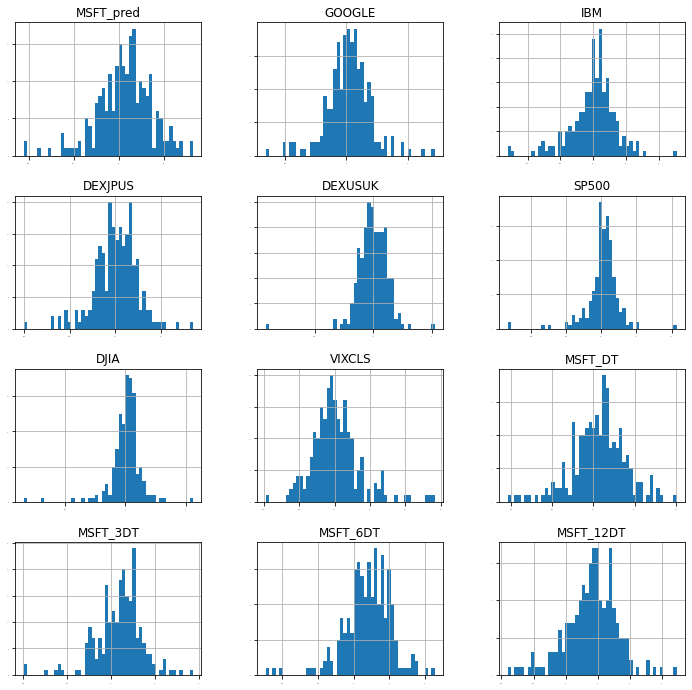

In [151]:
df.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

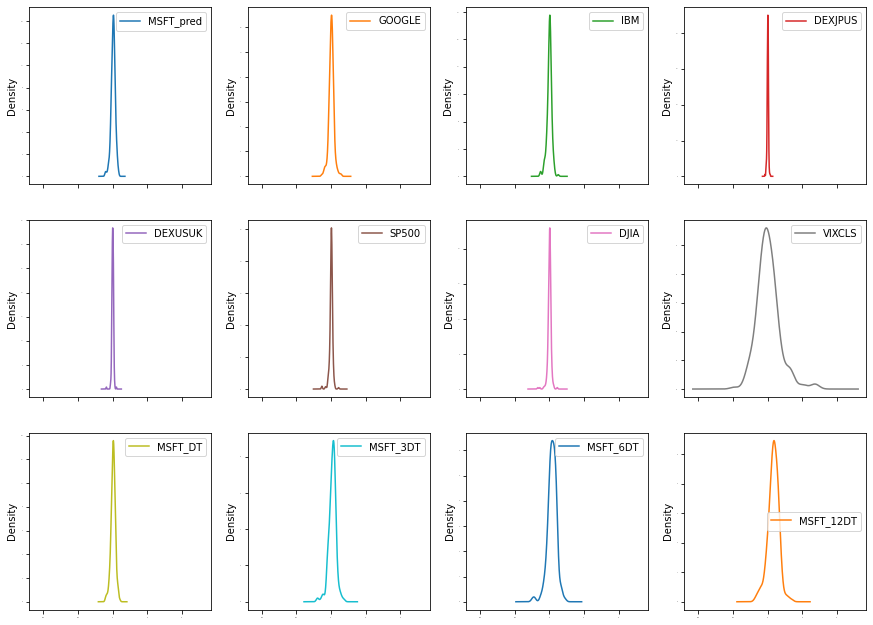

In [153]:
df.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
plt.show()

     VIX가 다른 분포들 보다 분산이 크다

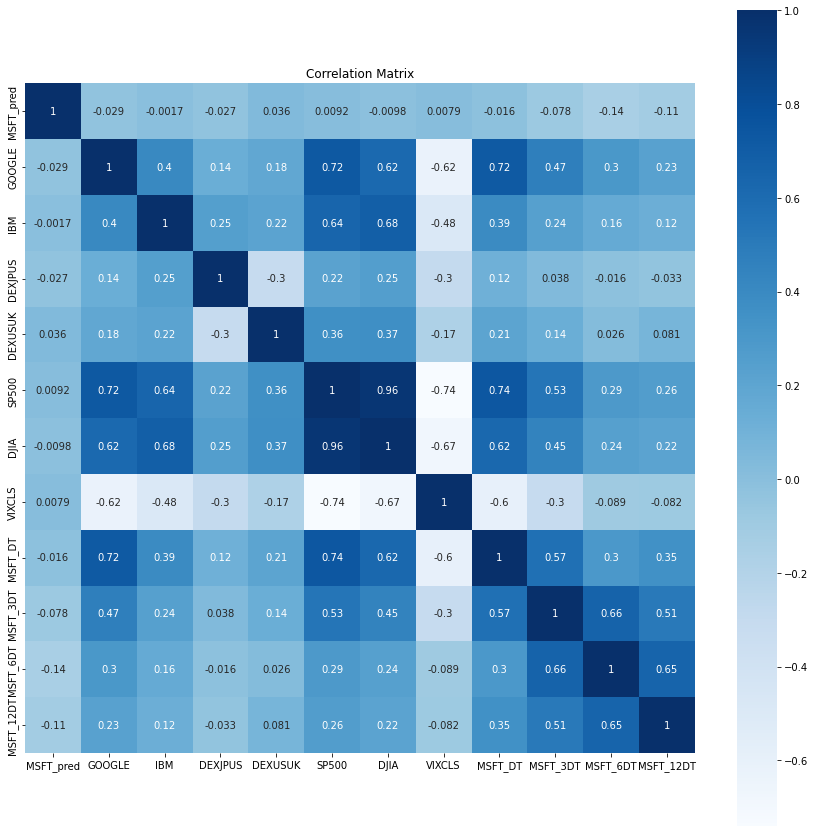

In [154]:
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='Blues')
plt.show()

예측 변수와 MSFT의 5일 지연,  15일 지연, 30일 지연, 60일 지연 수익 간의 상관관계를 알 수 있다. 또한 변동성 지수 대비 자산 수익 간에 강한 음의 상관관계가 있음을 알 수 있다.

<Figure size 1080x1080 with 0 Axes>

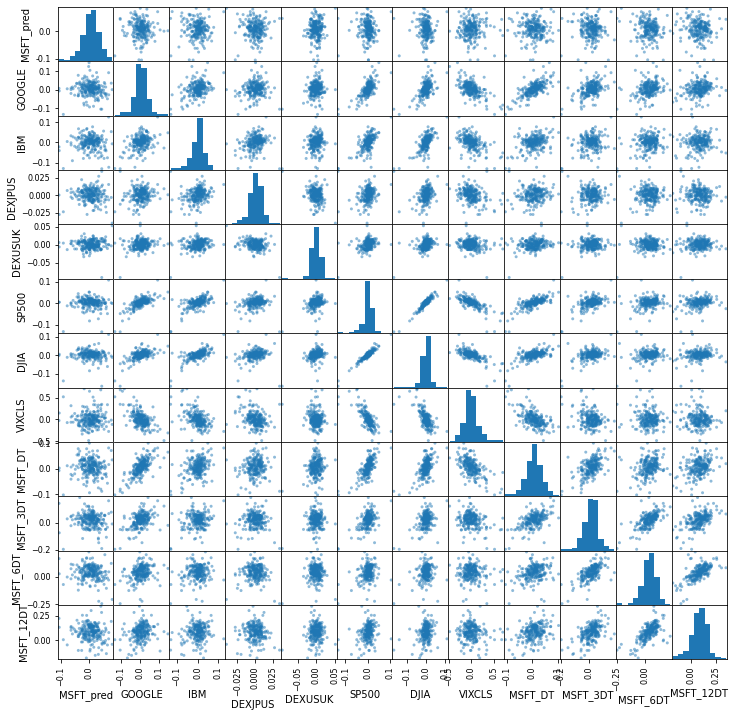

In [155]:
plt.figure(figsize=(15,15))
pd.plotting.scatter_matrix(dataset,figsize=(12,12))
plt.show()

예측변수와 MSFT의 5일 지연,  15일 지연, 30일 지연, 60일 지연 수익 간의 상관관계를 알 수 있다. 하지만 예측변수와 특성 간에는 특별한 관계가 없어 보인다.

### 시계열 분석

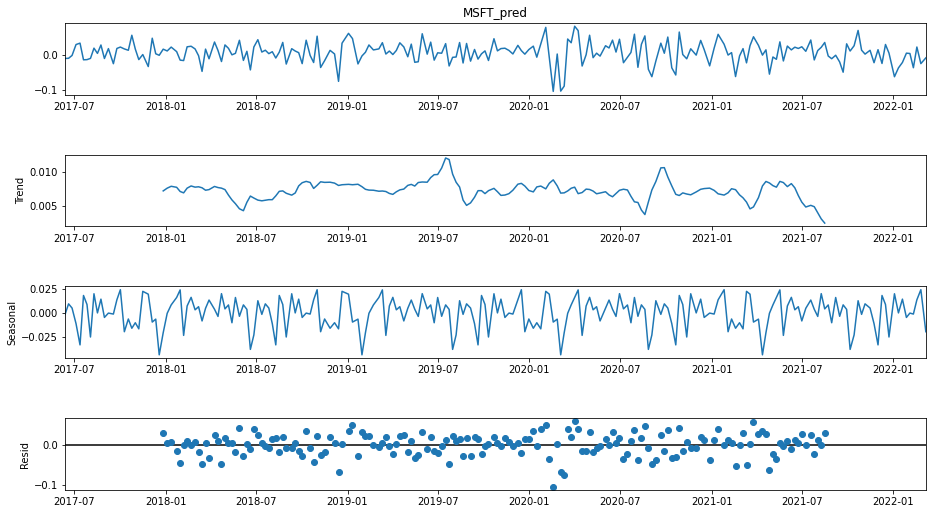

In [156]:
# 예측 변수의 시계열 추세와 계절성 구성요소 재구성 후 관찰 
# seasonal_decompose함수는 seasonal 데이터를 트렌드와 주기성을 살펴보는데 사용
res = sm.tsa.seasonal_decompose(Y,period =52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

Microsoft 최근 주가를 보면 코로나 확산으로 인한 급락과 반등이 눈에 띄며 그 이후로 등락을 반복하고 있는것으로 보인다.    

## 데이터 준비

### 특성 선택

In [157]:
# 성능이 좋은 변수만 사용하는 전처리기인 SelectKBest 
bestfeatures = SelectKBest(k=5, score_func=f_regression) # 분산분석(ANOVA) F검정 통계값
fit = bestfeatures.fit(X,Y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  
featureScores.nlargest(10,'Score').set_index('Specs')  

,Score
Specs,
MSFT_6DT,4.756412
MSFT_12DT,2.905035
MSFT_3DT,1.376860
DEXUSUK,0.291996
GOOGLE,0.185592
DEXJPUS,0.167730
MSFT_DT,0.056800
DJIA,0.021631
SP500,0.019042


## 알고리즘과 모델 평가

###  테스트 데이터 분할 및 평가 메트릭

시계열 데이터에서는 값의 순서가 중요하다. 따라서 임의의 방식으로 데이터 셋을 훈련셋과 테스트셋으로 나누지 않지만 , 이 문제에서는 정렬된 관측치에서 무작위 분기점을 선택해 새로운 데이터 셋을 두개 만든다.

In [158]:
validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

### 테스트 옵션 및 평가 메트릭

모델에 있는 다양한 하이퍼파라미터를 최적화하기 위해 10-겹 교차검증을 사용해 결과를 10회 재계산, 모델 일부와 교차검증 과정에 (숨겨진 편향성을 제거하는) 임의성이 내재하기 때문이다. MSE를 오차 메트릭으로 사용해 알고리즘을 평가

In [159]:
num_folds = 10
seed = 7

scoring = 'neg_mean_squared_error' 

### 모델 및 알고리즘 비교

In [160]:
# 회귀와 트리 

models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [162]:
# 뉴럴 네트워크 

models.append(('MLP', MLPRegressor()))

In [164]:
# 부스팅 
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))

# 베깅
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [167]:
names = []
kfold_results = []
test_results = []
train_results = []

for name, model in models : 
    names.append(name) 
    kfold = KFold(n_splits = num_folds, random_state = seed, shuffle=True)
    # MSE를 양수로 변환 
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    
    # 총 훈련기간
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    #테스트 결과 
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.001066 (0.000456) 0.000868 0.000992
LASSO: 0.000963 (0.000421) 0.000953 0.000751
EN: 0.000963 (0.000421) 0.000953 0.000751
KNN: 0.001093 (0.000415) 0.000740 0.001027
CART: 0.002165 (0.001065) 0.000000 0.001609
SVR: 0.001314 (0.000332) 0.001308 0.000926
MLP: 0.001772 (0.000787) 0.003724 0.003527
ABR: 0.001126 (0.000497) 0.000457 0.001028
GBR: 0.001450 (0.000833) 0.000071 0.001343
RFR: 0.001175 (0.000525) 0.000160 0.001191
ETR: 0.001113 (0.000439) 0.000000 0.001277


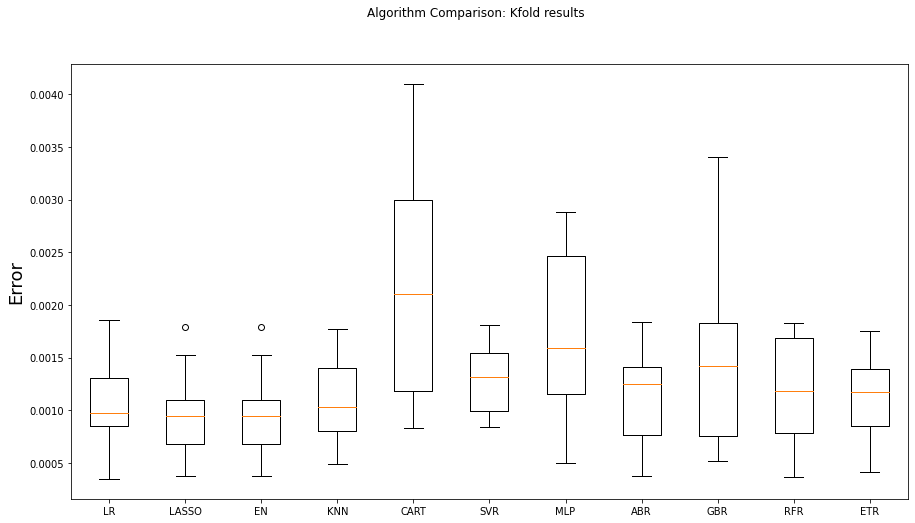

In [176]:
# 교차 검증 결과 

fig = plt.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.ylabel('Error', fontdict= {'fontsize' : 18})
plt.show()

라쏘회귀와 엘라스틱 넷을 포함한 선형회귀와 정규화 회귀모델이 가장 좋은 성능을 보인다. 이는 종속변수와 독립변수간에 강한 선형관계가 있음을 말해준다. 


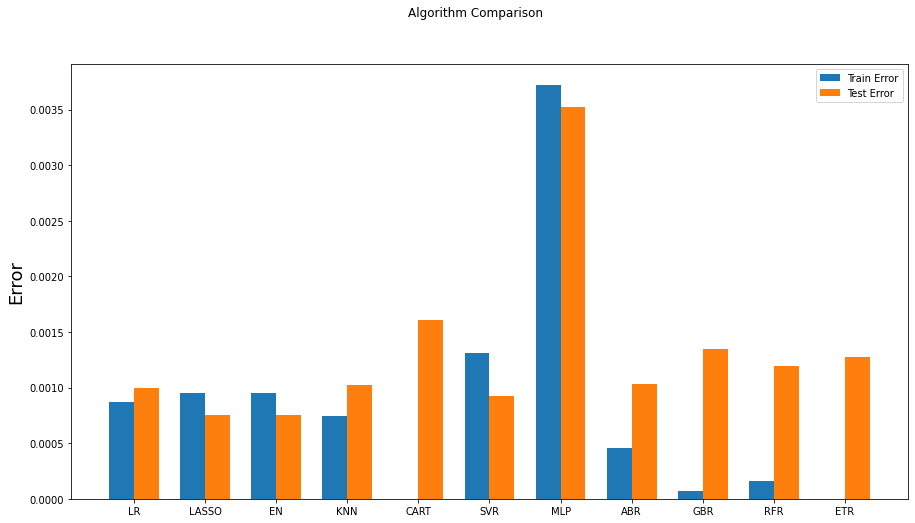

In [177]:
# 훈련 및 테스트 오차 

fig = plt.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.bar(ind - width/2, train_results,  width=width, label='Train Error')
plt.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.ylabel('Error', fontdict= {'fontsize' : 18})
plt.show()

선형 모델이 더 좋은 성능을 보인다. 결정트리(CART)와 같은 일부 알고리즘은 훈련데이터에 과적합되어 테스트셋에서 오차가 크게 나타난다. 경사 부스(GBR)과 랜덤포레스트(RFR)같은 앙상블 모델은 편향이 낮지만 분산이 높다. 또한 차트에서 MLP를 보듯이 인공 신경망 알고리즘은 훈련셋과 테스트셋 모두 오차가 크다.
이는 인공신경망, 부적당한 하이퍼파라미터 혹은 불충분한 모델 훈련으로 인해 변수 간의 선형 관계를 찾아내지 못했기 때문이다.

### 시계열 기반 모델 : ARIMA 및 LSTM

지금까지 사용한 모델에는 지연변수를 독립변수로 포함하는 시간 지연 접근방법을 사용한 시계열 구성요소가 있었다. 하지만 시계열 기반 모델에서는 독립변수로 MSFT의 지연변수를 포함할 필요가 없다. 따라서 첫 번째 단계에서 MSFT의 이전 수익을 모델에서 제거하고 다른 모델 변수를 외생변수로 사용한다.

* 외생변수는 독립변수 이외의 변수로 종속변수에 영향을 줘 이를 통제하지 않을 시 연구결과의 내적타당도에 문제가 되는 변수

In [179]:
# ARIMA model 

X_train_ARIMA =X_train.loc[:, ['GOOGLE', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
X_test_ARIMA =X_test.loc[:, ['GOOGLE', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X)

In [194]:
#endog ( array-like ) – 내생 변수.
#order ( iterable ) – 사용할 AR 매개 변수, 차이 및 MA 매개 변수의 수에 대한 모델의 (p, d, q) 순서입니다.
#exog ( array-like , optional ) – 외생 변수의 선택적 배열. 여기 에는 상수 또는 추세가 포함 되지 않아야합니다 .

#from statsmodels.tsa.arima_model import ARIMA

#modelARIMA = ARIMA(endog= Y_train, exog= X_train_ARIMA, order=[1,0,0])
#model_fit = modelARIMA.fit()

#### LSTM 모델

LSTM 이면의 논리는 전일의 데이터(모든 특성이 포함된 데이터, 즉 MSFT의 상관 자산과 지연변수)를 입력으로 취하고 익일의 값을 예측하는 것이다. 그 다음 하루를 이동해 같은 방식으로 다음날의 값을 예측 한다. 전체 데이터셋에 이 과정을 반복

In [187]:
seq_len = 2 

Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))

for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]

LSTM층에 있는 50개의 은닉 유닛을 통과해 주식 수익값으로 변환

In [188]:
def create_LSTMmodel(neurons=12, learn_rate = 0.01, momentum=0):
        
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    
    model.add(Dense(1))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='adam')
    return model

LSTMModel = create_LSTMmodel(12, learn_rate = 0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM),
                              epochs=330, batch_size=72, verbose=0, shuffle=False)

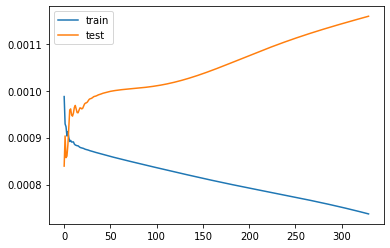

In [190]:
plt.plot(LSTMModel_fit.history['loss'], label='train')
plt.plot(LSTMModel_fit.history['val_loss'], label='test')
plt.legend()
plt.show()

In [191]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test,predicted)

In [192]:
#test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)

#train_results.append(error_Training_ARIMA)
train_results.append(error_Training_LSTM)

#names.append("ARIMA")
names.append("LSTM")

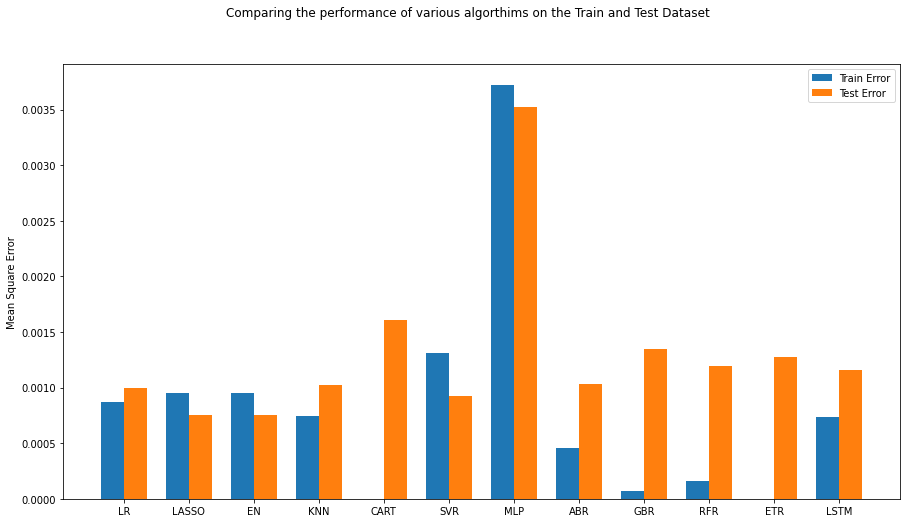

In [193]:
# 모든 알고리즘 비교

fig = plt.figure()

ind = np.arange(len(names))  
width = 0.35  

fig.suptitle('Comparing the performance of various algorthims on the Train and Test Dataset')
ax = fig.add_subplot(111)
plt.bar(ind - width/2, train_results,  width=width, label='Train Error')
plt.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.ylabel('Mean Square Error')
plt.show()

### 모델 튜닝 및 격자 탐색 

In [ ]:
def evaluate_arima_model(arima_order):
    
#endog ( array-like ) – 내생 변수.
#order ( iterable ) – 사용할 AR 매개 변수, 차이 및 MA 매개 변수의 수에 대한 모델의 (p, d, q) 순서입니다.
#exog ( array-like , optional ) – 외생 변수의 선택적 배열. 여기 에는 상수 또는 추세가 포함 되지 않아야합니다 .

    modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=arima_order)
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error
 
# ARIMA 모델에 대한 p, d, q값 조합 평가 
# p = 자기회귀 부분의 차수
# d = 1차 차분이 포함된 정도
# q = 이동 평균 부분의 차수
def evaluate_models(p_values, d_values, q_values): 
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)                
                try:
                    mse = evaluate_arima_model(order)                    
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))
    
# 매개변수 평가 
p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)   

In [ ]:
# output

ARIMA(0, 0, 0) MSE=0.0009318
ARIMA(0, 0, 1) MSE=0.0008887
ARIMA(1, 0, 0) MSE=0.0008877
ARIMA(1, 0, 1) MSE=0.0008871
ARIMA(2, 0, 0) MSE=0.0008874
ARIMA(2, 0, 1) MSE=0.0008329
Best ARIMA(2, 0, 1) MSE=0.0008329

다른 조합과 비교해서 MSE 값이 크게 차이 나지 않지만, (2, 0, 1) 차수를 갖는 ARIMA 모델이 격자 탐색에서 가장 좋은 성능을 보임을 알 수 있다.  
자기 회귀의 지연2와 이동평균 1이 있는 모델이 가장 좋은 결과를 낸다는 의미이다. 

## 모델 확정

### 테스트셋에 대한 결과

In [ ]:
# 모델 준비

modelARIMA_tuned=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[2,0,1])
model_fit_tuned = modelARIMA_tuned.fit()

# 검증셋에 대한 정확도 추정 

predicted_tuned = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(Y_test,predicted_tuned))

In [ ]:
# output

0.0015358349044173017

In [ ]:
# 시각화 코드 

# predicted_tuned.index = Y_test.index
# pyplot.plot(np.exp(Y_test).cumprod(), 'r') # plotting t, a separately
# pyplot.plot(np.exp(predicted_tuned).cumprod(), 'b')
# pyplot.rcParams["figure.figsize"] = (8,5)
# pyplot.show()

### 결론

선형 회귀, 정규화 회귀(라쏘와 엘라스텍 넷) 같은 간단한 모델부터 ARIMA 같은 시계열 모델이 주가 예측 문제를 다루는데 유망하다고 결론 내릴 수 있다.   
이런 모델은 금융예측에서 도전적인 문제가 되는 적합과 과소적합을 다루는데 유용하다.  

또한 주가 수익 비율, 거래량, 기술 지표, 뉴스 데이터를 폭 넓게 사용한다면 더 좋은 결과를 도출 할 수 있다. 